In [1]:
from syba import syba
import mols2grid

s = syba.SybaClassifier()
s.fitDefaultScore()


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

100%|██████████| 113/113 [00:00<00:00, 162815.65it/s]

MolGridWidget()


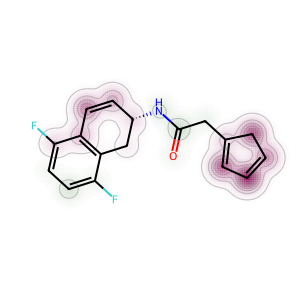
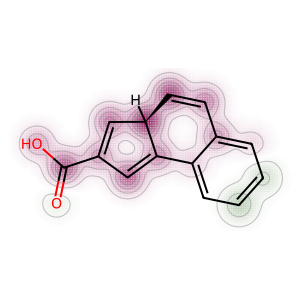
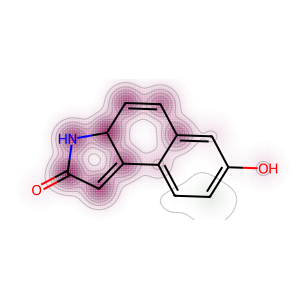
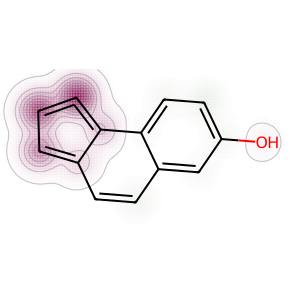
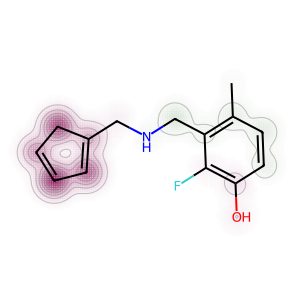
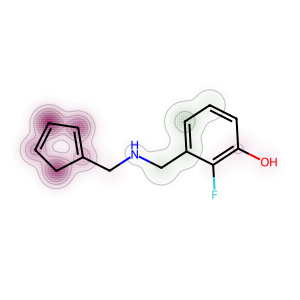
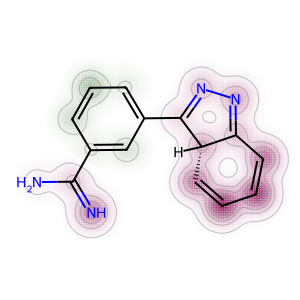
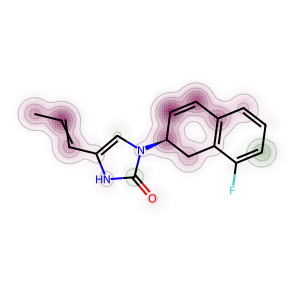
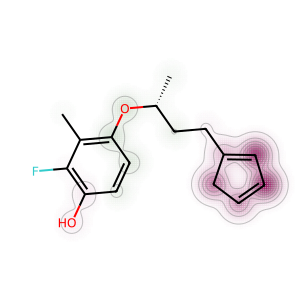
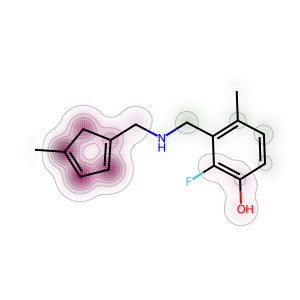
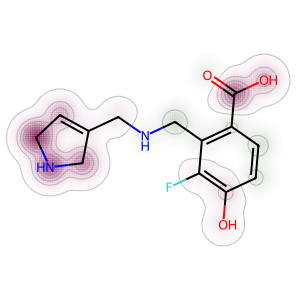
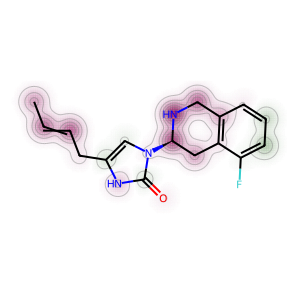
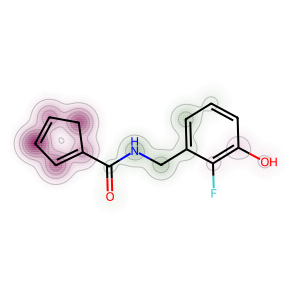
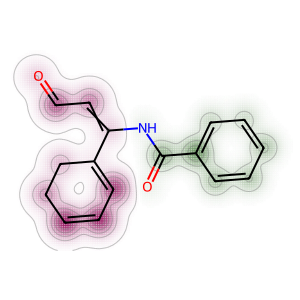
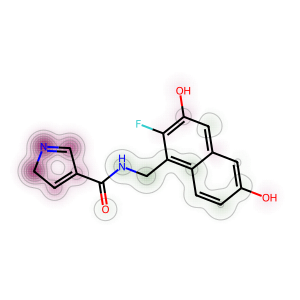
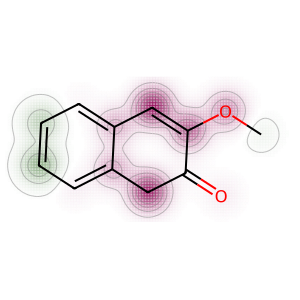
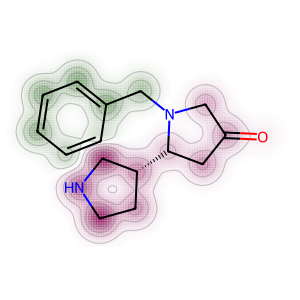
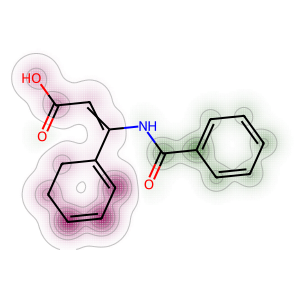
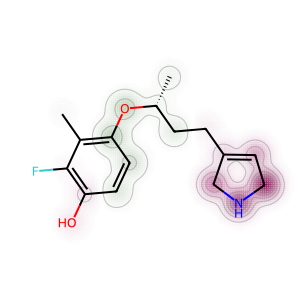
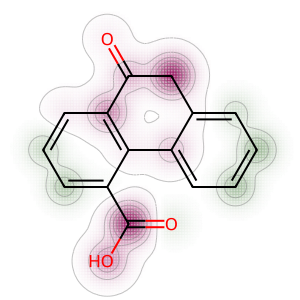
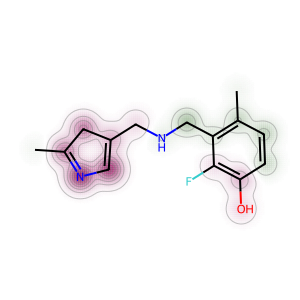
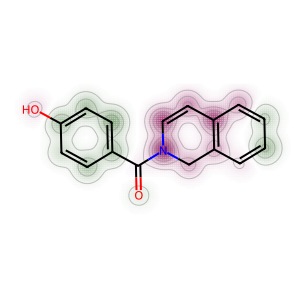
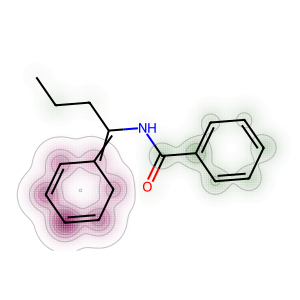
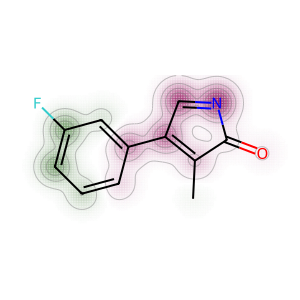
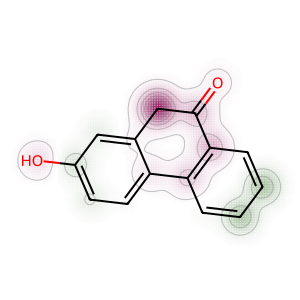
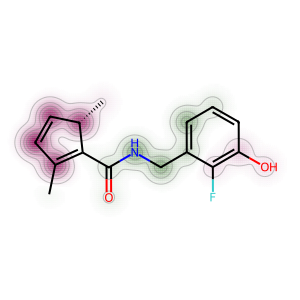
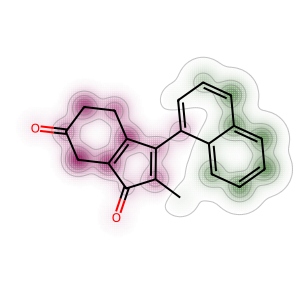
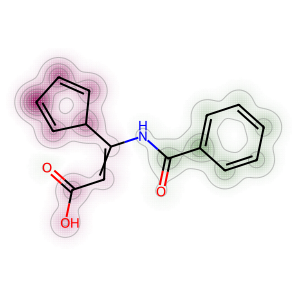
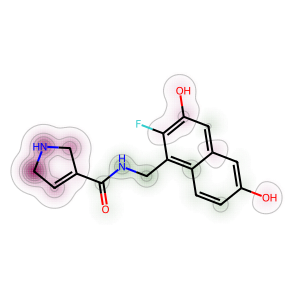
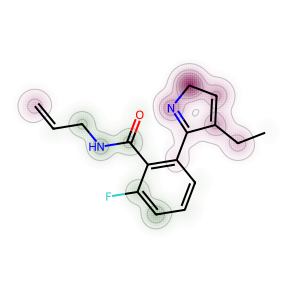
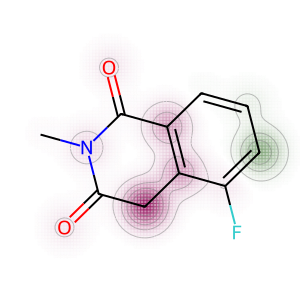
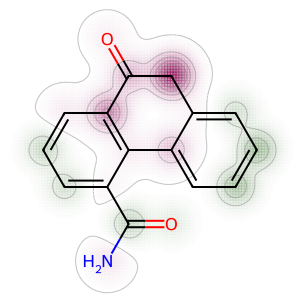
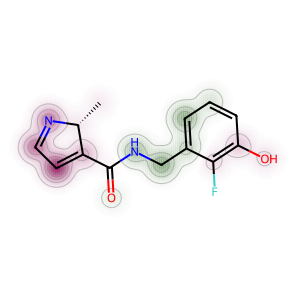
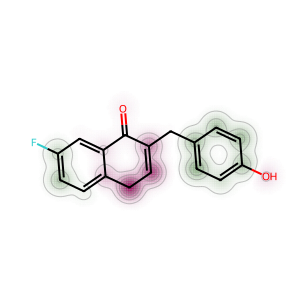
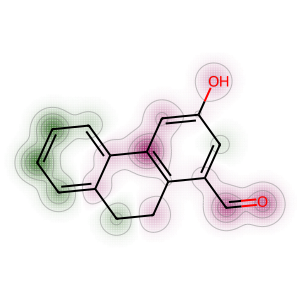
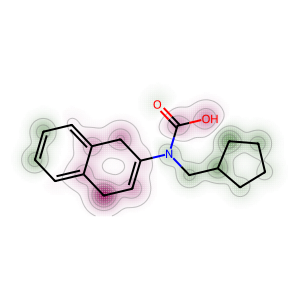
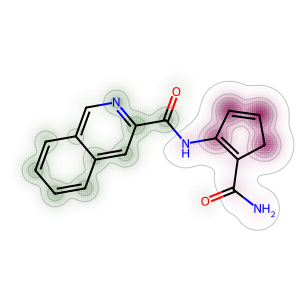
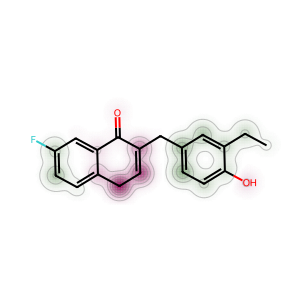
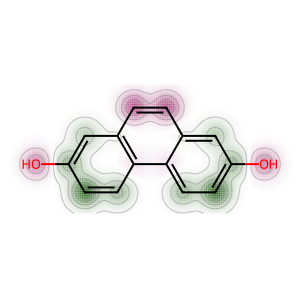
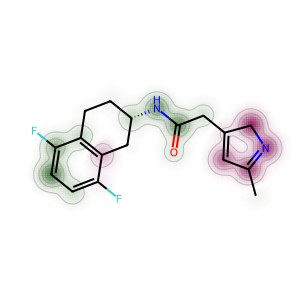
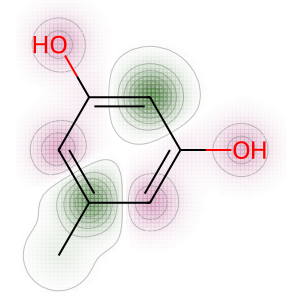
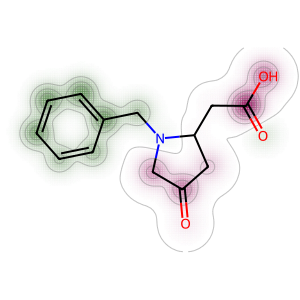
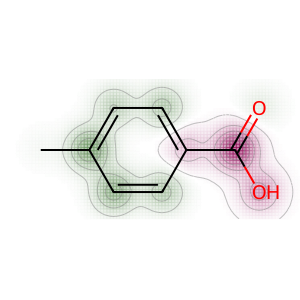
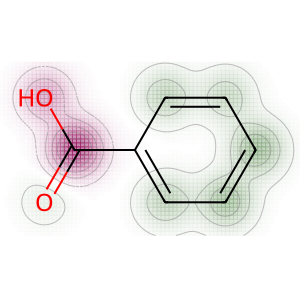
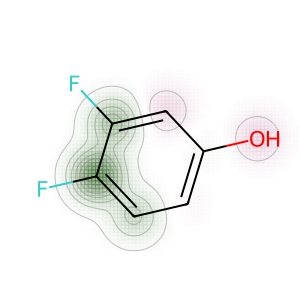
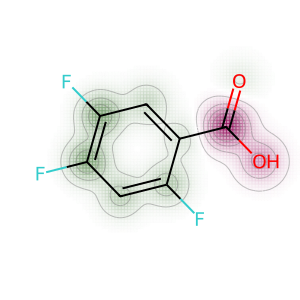
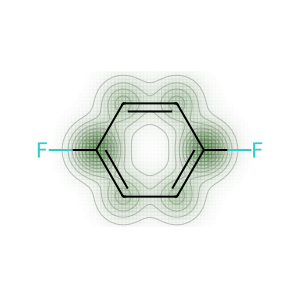
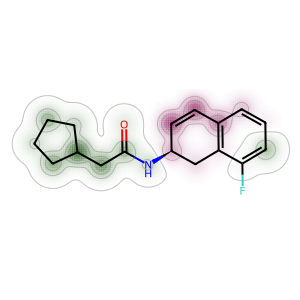
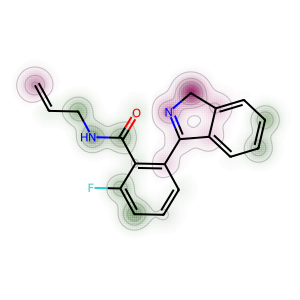
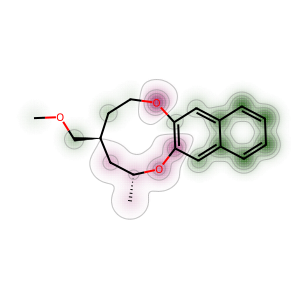
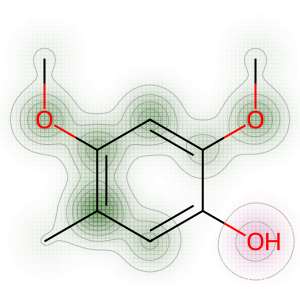
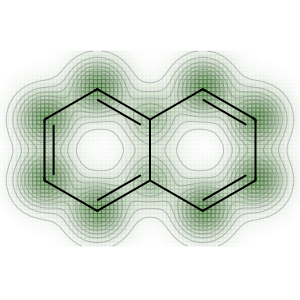
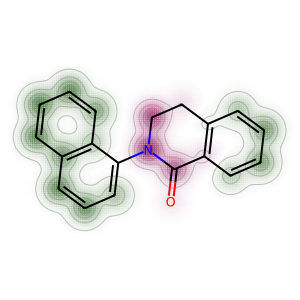
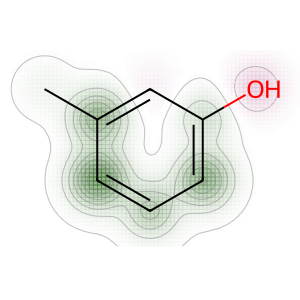
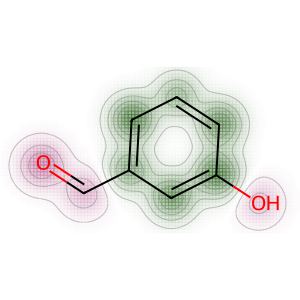
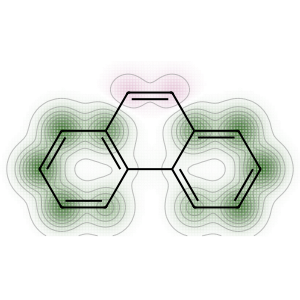
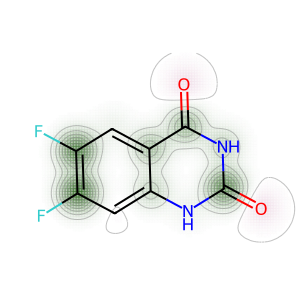
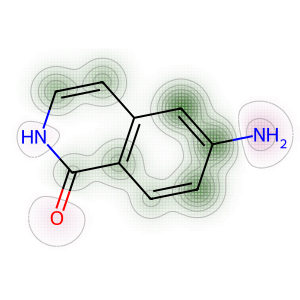
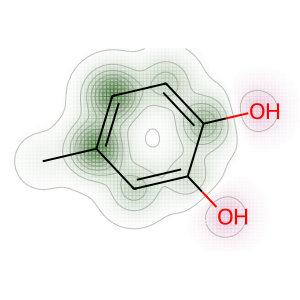
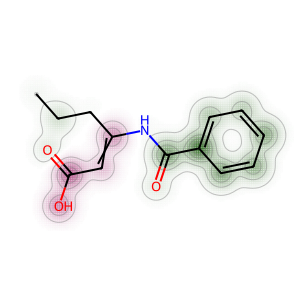
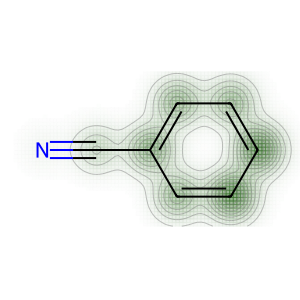
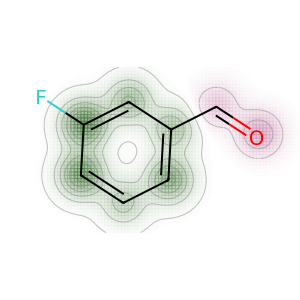
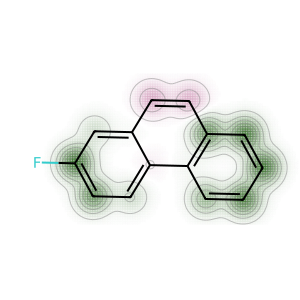
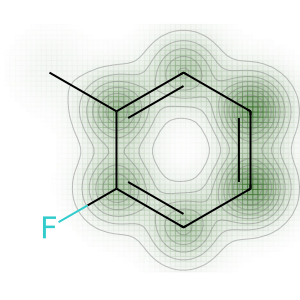
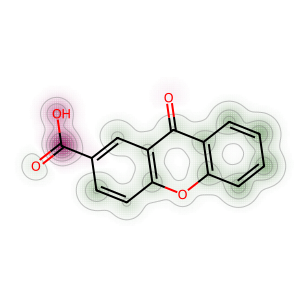
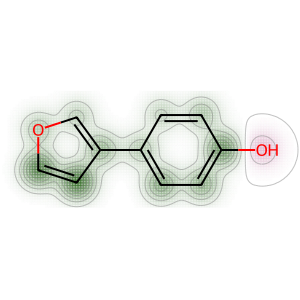
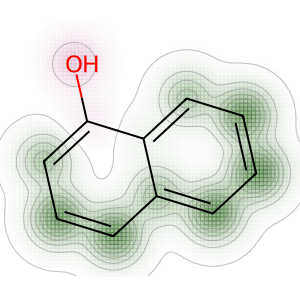
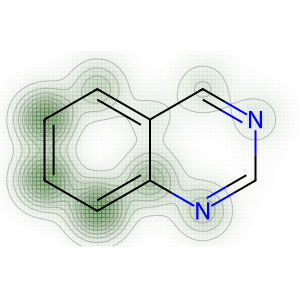
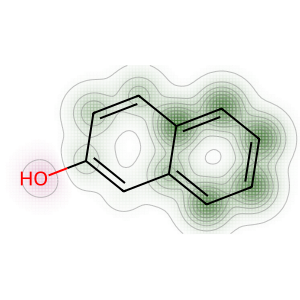
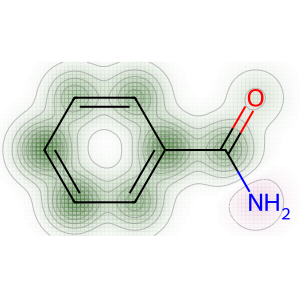
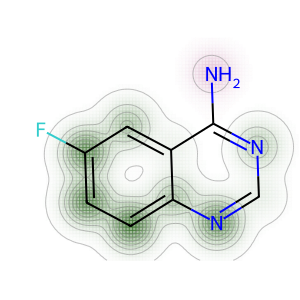
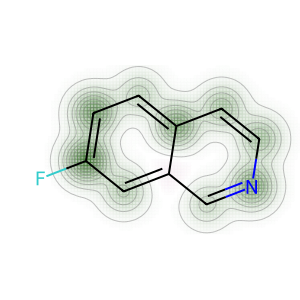
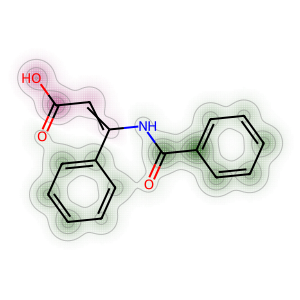
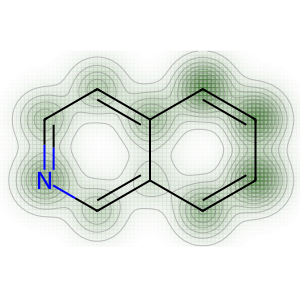
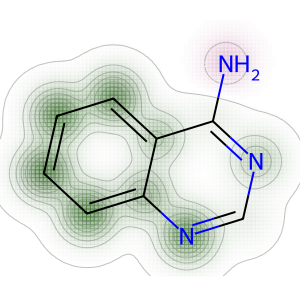
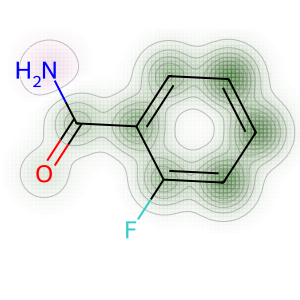
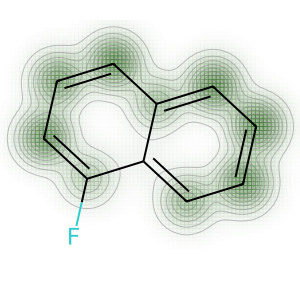
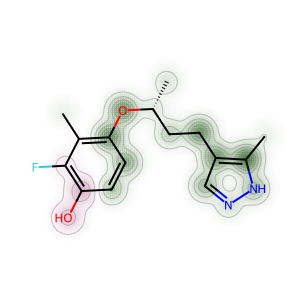
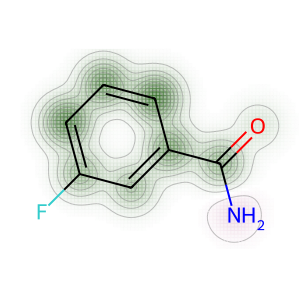
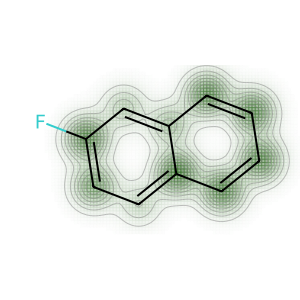
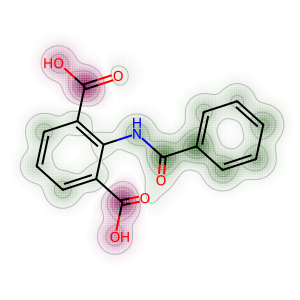
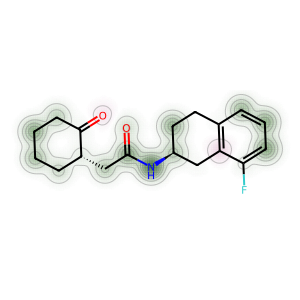
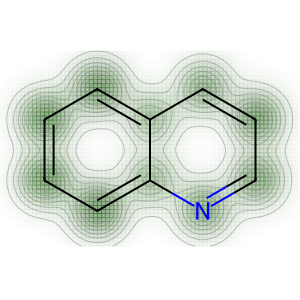
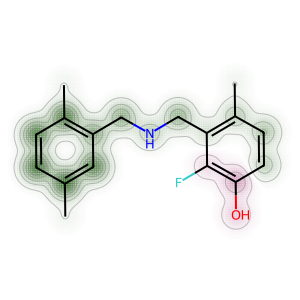
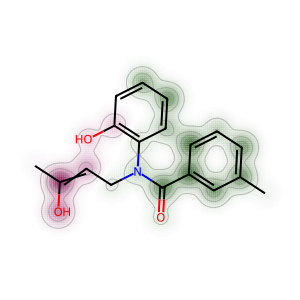
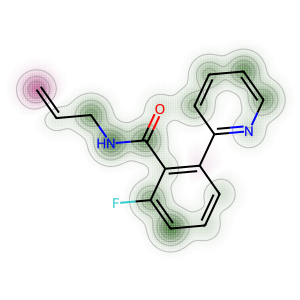
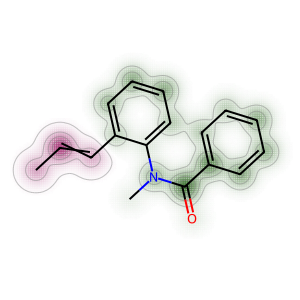
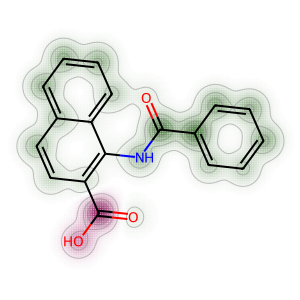
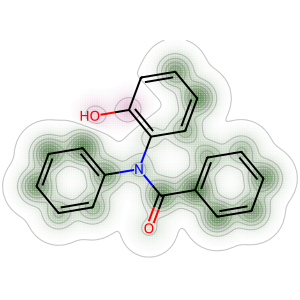
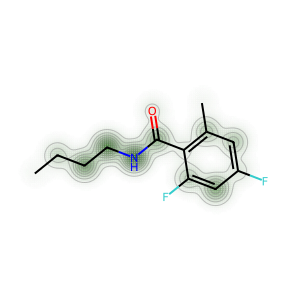
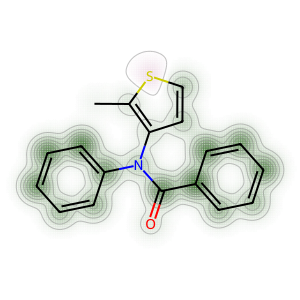
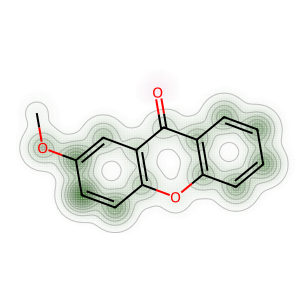
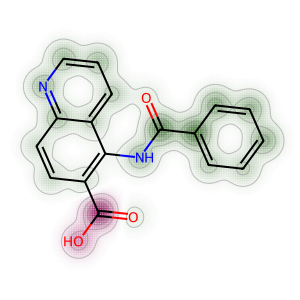
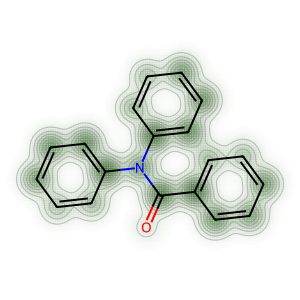
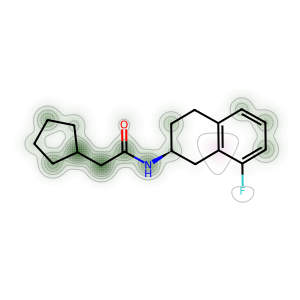
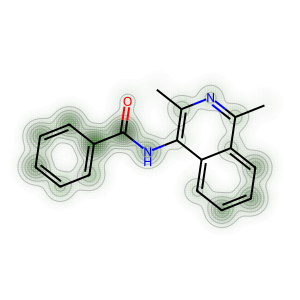
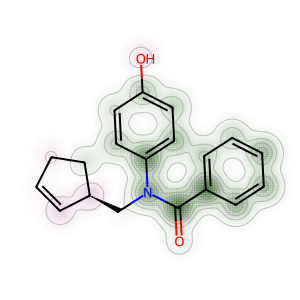
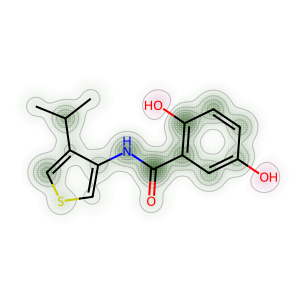
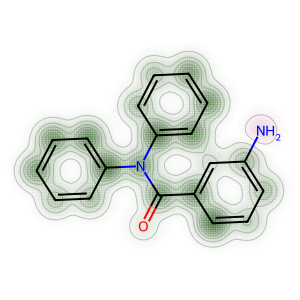
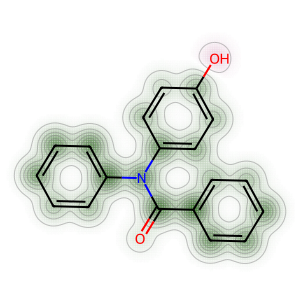
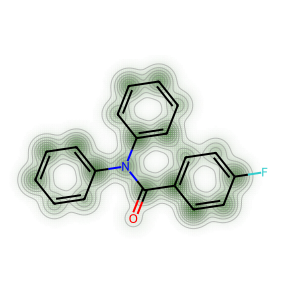
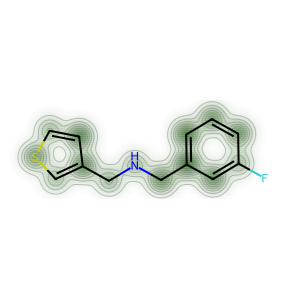
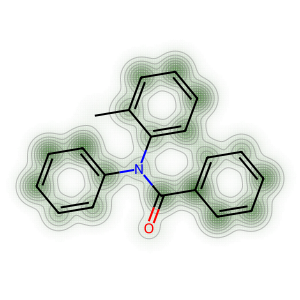
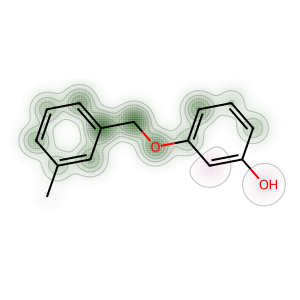
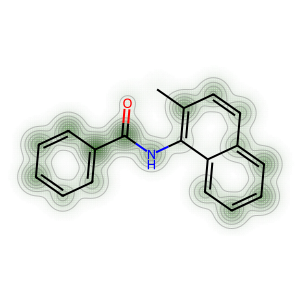
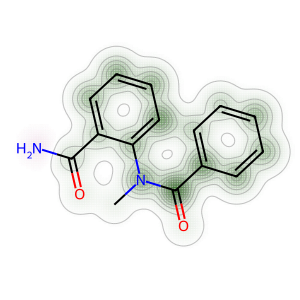
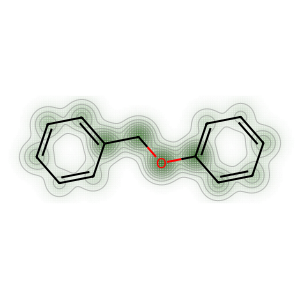
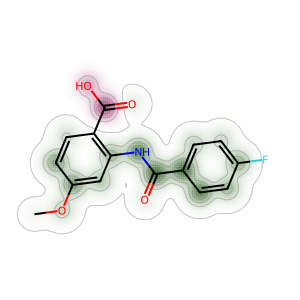
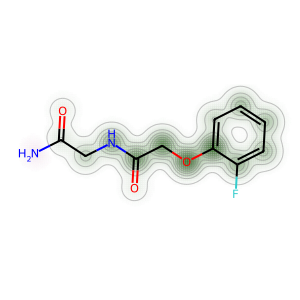
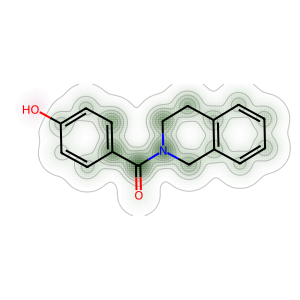
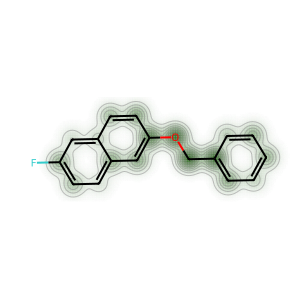
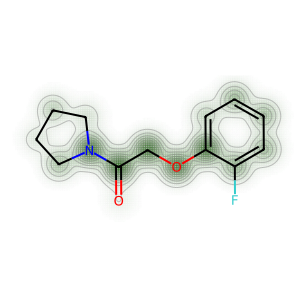
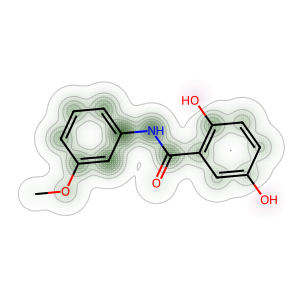

In [2]:
import base64
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import SimilarityMaps
import mols2grid
from IPython.display import display as ipy_display
from joblib import Parallel, delayed
from tqdm import tqdm

def process_mol_record(mol, syba, use_3d, image_size):
    if not use_3d:
        mol.RemoveAllConformers()
        rdDepictor.Compute2DCoords(mol)
    smiles = Chem.MolToSmiles(mol)
    score = syba.predict(mol=mol)
    d = Draw.MolDraw2DCairo(image_size[0], image_size[1])
    contrib = syba.fragment_contribution(mol=mol)
    SimilarityMaps.GetSimilarityMapFromWeights(mol, contrib, draw2d=d)
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    b64_img = base64.b64encode(png_data).decode("utf-8")
    img_html = f"<img src='data:image/png;base64,{b64_img}'/>"
    return {"SMILES": smiles, "SYBA_score": score, "mol": mol, "img": img_html}

class SDFGridViewer:
    def __init__(self, sdf_path, syba_classifier, use_3d=False, image_size=(300, 300)):
        self.sdf_path = sdf_path
        self.syba = syba_classifier
        self.use_3d = use_3d
        self.image_size = image_size
        self.df = None

    def process_sdf(self):
        supplier = Chem.SDMolSupplier(self.sdf_path)
        mols = [mol for mol in supplier if mol is not None]
        records = Parallel(n_jobs=-1, backend="threading")(
            delayed(process_mol_record)(mol, self.syba, self.use_3d, self.image_size) for mol in tqdm(mols)
        )
        self.df = pd.DataFrame(records)
        return self.df

    def display_grid(self):
        if self.df is None:
            print("DataFrame is empty, run process_sdf() first.")
            return
        grid = mols2grid.MolGrid(
            self.df,
            smiles_col="SMILES",
            mol_col="mol",
            subset=["img", "SYBA_score"],
            tooltip=["SMILES", "SYBA_score"],
            size=(120, 100),
            prerender=True
        )
        grid.mol_to_img = lambda m: self.df.loc[self.df["SMILES"] == Chem.MolToSmiles(m), "img"].iloc[0]
        grid._prepare_dataframe(grid.dataframe)
        html_obj = grid.display(
            style={
                "SYBA_score": lambda x: "color: red; font-weight: bold;" if x < 0 else "",
                "__all__": lambda x: "background-color: azure;" if x["SYBA_score"] > 0 else ""
            },
            transform={"SYBA_score": lambda x: round(x, 2)},
            sort_by="SYBA_score"
        )
        ipy_display(html_obj)

    def show(self):
        self.process_sdf()
        self.display_grid()

viewer = SDFGridViewer("6gj7_F0B_ligand_gen.sdf", s, use_3d=False)
viewer.show()